# Earthquake predictor ML workflow

`By aditya srichandan`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing;
from sklearn import model_selection;
from sklearn import linear_model;
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import xgboost as xgb

#### Load training and prediction window data from saved sql database

In [2]:
engine =create_engine('sqlite:///../Data/Earthquakedata.db')
df_features = pd.read_sql_table('Earthquake_features',con=engine)

In [3]:
df_features.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2020-07-27,76.37,4.2,Papua New Guinea,-5.297074,148.894953,63.765909,67.072000,79.460000,4.550000,4.573333,4.500000,1
1,2020-07-28,88.76,4.3,Papua New Guinea,-5.297074,148.894953,61.451364,67.670000,78.664286,4.540909,4.393333,4.485714,1
2,2020-07-29,83.01,4.4,Papua New Guinea,-5.297074,148.894953,64.770000,66.487333,86.885714,4.545455,4.366667,4.485714,1
3,2020-07-30,10.00,4.9,Papua New Guinea,-5.297074,148.894953,64.770000,64.040000,85.245714,4.545455,4.426667,4.571429,1
4,2020-07-31,195.88,4.3,Papua New Guinea,-5.297074,148.894953,73.219091,75.197333,102.524286,4.531818,4.426667,4.500000,1


In [4]:
engine =create_engine('sqlite:///../Data/Earthquakedata_predict.db')
df_predict = pd.read_sql_table('Earthquake_predict',con=engine)

In [5]:
# Live data to be predicted on after being trained of rolling period for next 7 days. 
#Hence NaN outcome that has to be predicted

df_predict.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2020-08-03,140.81,4.4,Papua New Guinea,-5.297074,148.894953,73.251364,70.354000,83.355714,4.718182,4.820000,4.942857,NaN
1,2020-08-04,172.48,5.4,Papua New Guinea,-5.297074,148.894953,76.803636,75.935333,106.567143,4.763636,4.893333,4.857143,NaN
2,2020-08-05,94.65,5.0,Papua New Guinea,-5.297074,148.894953,79.948636,76.711333,105.600000,4.790909,4.933333,4.971429,NaN
3,2020-08-06,196.24,4.8,Papua New Guinea,-5.297074,148.894953,87.892273,89.127333,113.395714,4.813636,4.926667,5.071429,NaN
4,2020-08-06,85.48,4.7,Papua New Guinea,-5.297074,148.894953,88.371818,81.767333,124.178571,4.809091,4.953333,4.914286,NaN


#### Training is done by considering 22, 15, 7 days window past features rolling average and outcome data is shifted to next 7 days as prediction.

In [6]:
# Selection of features that are needed for prediction and hence consider only them rest are just ignored for prediction purpose.

features = [f for f in list(df_features) if f not in ['date', 'lon_box_mean',
 'lat_box_mean', 'mag_outcome', 'mag', 'place',
 'combo_box_mean',  'latitude',
 'longitude']]

# splitting traing and testing dataset with trainging size = 70% and test = 30%
X_train, X_test, y_train, y_test = train_test_split(df_features[features],
                     df_features['mag_outcome'], test_size=0.3, random_state=42)
  

In [7]:
features

['depth',
 'depth_avg_22',
 'depth_avg_15',
 'depth_avg_7',
 'mag_avg_22',
 'mag_avg_15',
 'mag_avg_7']

#### Training phase

* Models used are : 
    * Adaboost classifier with DecisionTree 
    * Adaboost classifier with RandomForest
    * GridSearch CV as hyper parameter tunning
    

* Model used for Deployment of application :
    * Xgboost with parameters set from above models

#### Adaboost Decision Tree Classifier

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
              "base_estimator__max_depth" :   [2,5,7],
              "n_estimators": [200, 400, 600]
             }

# base estimator
tree = DecisionTreeClassifier()

# adaboost with the tree as base estimator
# learning rate is arbitrarily set to 0.6,
ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    algorithm="SAMME")

#### Parameter tunning with GridSearch CV

In [9]:
# run grid search
grid_search_ABC = GridSearchCV(ABC,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1)

In [10]:
grid_search_ABC.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  6.0min finished


GridSearchCV(estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(),
                                          learning_rate=0.6),
             param_grid={'base_estimator__max_depth': [2, 5, 7],
                         'n_estimators': [200, 400, 600]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [11]:
pred_ABC=grid_search_ABC.predict(X_test)

### Evaluation Area Under curve & ROC 

I have chose ROC_AUC score as evaluation metric since I have to binary classifify wether earthquake happened or not with given features that has been train on past few days window rolling average window.

 * With **adaboost decision tree classifier** and hyper parameter tunning, we get area under curve (score) = 0.8867
 * higher the auc score, better is the model since it is better at distinguishing postive and negative classes.
 * Make a note here that we get from **confusion matrix**, `False negative = 42`and `Recall score =0.7789`. We need this value apart from auc score that we will analyze later when we have tested with diffferent models below

0.8869826795052952
AUC: 0.887


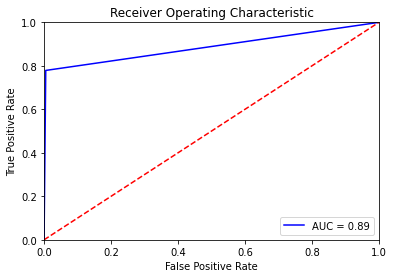

Confusion Matrix: 
 [[3595   18]
 [  42  148]]

Recall 'TP/TP+FN' =  0.7789473684210526


In [12]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

print(roc_auc_score(y_test, pred_ABC))

fpr, tpr, _ = roc_curve(y_test, pred_ABC)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


print("Confusion Matrix: \n",confusion_matrix(y_test,pred_ABC))
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,pred_ABC))

#### Adaboost Random Forest Classifier

In [13]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}
# GridSearch of parameter tunning.
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features='sqrt',
                                              n_estimators=50, n_jobs=-1,
                                              oob_score=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 700]})

In [14]:
pred=CV_rfc.predict(X_test)

### Evaluation Area Under curve & ROC 

* Below is the auc score for **adaboost RandomForest classifier** with 0.916 which is slightly lower than Decision tree classifier
* Moreover when we look at **confusion matrix**, `False Negative=38` and `Recall score = 0.8' can be observed which is slightly higher than recall score of decision tree. Thus performs better than decision tree adabooost 

0.8993102393403936
AUC: 0.8993


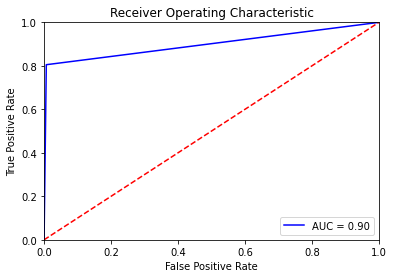

Confusion Matrix: 
 [[3589   24]
 [  37  153]]

Recall 'TP/TP+FN' =  0.8052631578947368


In [15]:

print(roc_auc_score(y_test, pred))

fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


print("Confusion Matrix: \n",confusion_matrix(y_test,pred))
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,pred))

#### XGBoost 
* I have also tested with xgboost model below with similar parameters as I got above, since grid search CV was taking lot of time for xgboost.
 * As we can see this significantly gives higher AUC score of almost 0.0.98 and also `False negative = 37` which is similar Random Forest adaboost but xgboost has higher True positive and less False Positve compared to Random forest adaboost. i.e `Recall score = 0.805` which is similar adaboost Random Forrest tree. But XGboost is really good at classifying positive and negative classes and also better `aur_roc_score = 0.98193`. 

[17:12:03] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.9819322038836364
AUC: 0.9819


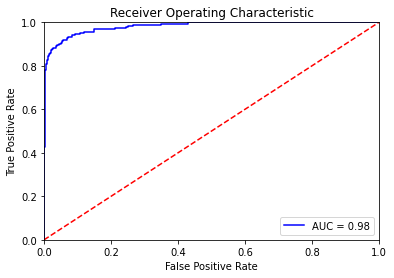

Confusion Matrix: 
 [[3590   23]
 [  37  153]]

Recall 'TP/TP+FN' =  0.8052631578947368


In [16]:
from sklearn.metrics import roc_curve, auc

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

param = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'max_depth': 6,  # the maximum depth of each tree
        'eta': 0.003,  # the training step for each iteration
        'silent': 1}  # logging mode - quiet}  # the number of classes that exist in this datset
num_round = 5000  # the number of training iterations    
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)

print (roc_auc_score(y_test, preds))
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

ypred_bst = np.array(bst.predict(dtest,ntree_limit=bst.best_iteration))
ypred_bst  = ypred_bst > 0.5
ypred_bst = ypred_bst.astype(int)  

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("Confusion Matrix: \n",confusion_matrix(y_test,ypred_bst))
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,ypred_bst))

We can see above that xgboost algorithm has higher auc score (0.9819) than adaboost decision tree and random forest, as it is evident from the ROC curve. Hence we consider xgboost for prediction of live data

### Final thoughts on which model to consider on application:
* Our main Aim is to predict wether earthquake will happen or not at a given day and place. So we definitely would **not like the model with higher False Neagtive values , since its more dangerous to predict as no earthquake while in reality earthquake happend than predicting earthquake will happen given in reality it did not**. Since its `better safe than sorry!!`, we can allow False positive more than False negative 

* After seeing these comparision on auc_roc score, confusion matrix, and recall score, since all the above algorithm have given similar result with slightly different recall scores, Xgboost with `FN=37` but with higher `auc_score 0f 0.98` performs over-all better. Hence for webapplication deployment, I have chosen Xgboost as it also faster than adaboost

#### Preparing prediction and plot for live unknown data we got in `df_predict` with `mag_outcome = Nan`

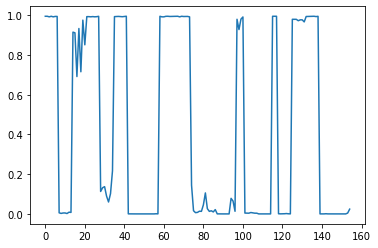

In [17]:

dlive = xgb.DMatrix(df_predict[features]) #, label=[])
preds = bst.predict(dlive)

plt.plot(preds)
plt.show()

### Prediction 

* Select specific features such as `data`,`place`,`long`,`lat` and give earthquake probablity from prediction at that place and date as `quake` probability
* with taking only 7 days rolling period data from predict dataframe since this outcome value is NaN and we need to predict next 7 days period.

In [24]:
live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
live_set.loc[:,'quake'] = preds
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='d')

live_set.tail()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,date,place,latitude,longitude,quake
75,2020-08-18,Hawaii,19.282855,-155.420908,0.004593
76,2020-08-18,Indonesia,-4.186166,119.931170,0.995564
77,2020-08-18,Nevada,38.177047,-117.932016,0.000078
78,2020-08-18,Philippines,7.507142,125.354826,0.994634
79,2020-08-18,Puerto Rico,17.974638,-66.897354,0.913831


In [25]:
import datetime as dt
# convert date to proper format for prediction
days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.today().strftime('%Y-%m-%d')]))
days.sort()

# Predict NaN outcome value in earthquake for next day 1.
predict_day=days[2]
predict_day

'2020-08-14'

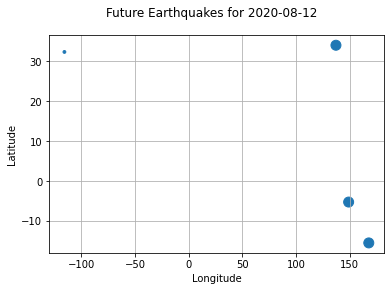

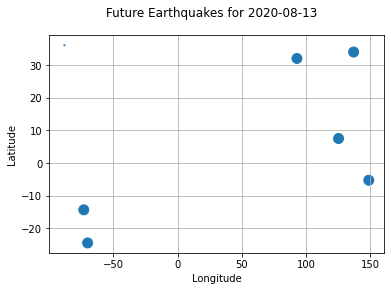

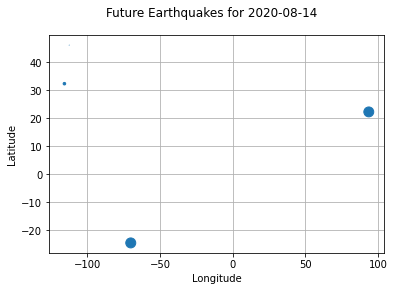

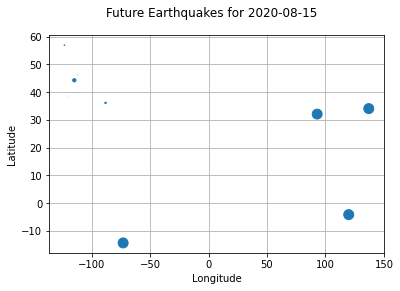

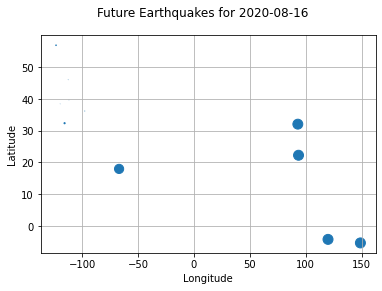

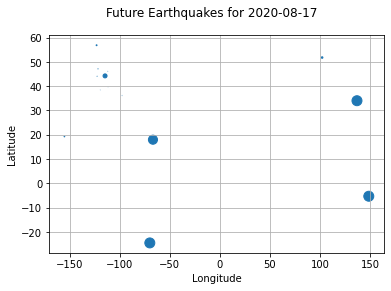

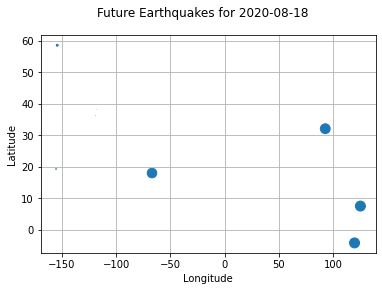

In [26]:
# place, date, lat and long with earthquake probability for next 7 days
for i in range(0,7):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
    plt.suptitle('Future Earthquakes for ' + days[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()

### Final thoughts:


1. So far the model looks good with xgboost as chosen model for predictions in web app haveing higher auc score and higher recall_score as I have explained under XGBoost result section why auc and recall score are chosen.


2. Now its time to deploy the model on web application with flask and I have chosen it to deploy on https://www.pythonanywhere.com/ which is a free hosting cloud platform for web flask applications.


3. Main Idea of Application will be predicting or forecasting these earthquake sites on given day all over the world.


4. The user has option to change the date using a slider and see look at predicted places where earthquake is likely to happen.


**Sample web app**
![SampleImage](https://github.com/aditya-167/Realtime-Earthquake-forecasting/blob/master/Images/application.jpg)

As you can see the webapplication has a slider to choose date and the model will predict places likely to have earthquake and predict its co-ordinate on the maps.

**Note** : co-ordinates need to be converted to google maps api format, that has been done in main.py file for flask. Also The ML workflow (this notebook) have modeling and prediction based on the USGS data I had worked on, but in the application, you will get real time data prediction which updates every minute, hence prediction and places may vary from above image as it depends on time of access of the app. 

**deployed app [link](http://srichaditya3098.pythonanywhere.com/)** 